In [0]:
import glob
import pandas as pd
from google.colab import files
from google.colab import drive
import numpy as np
import scipy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import random
import sys
import math
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from matplotlib.lines import Line2D

#Form correct data

In [0]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Knab/Data/CleanData"

ls: cannot access '/content/drive/My Drive/Knab/Data/CleanData': No such file or directory


In [0]:
#Load in required data
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")

In [0]:
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]

In [0]:
#All articles 
df = df[df['ArticleYN'] == 1]

In [0]:
upper_bound = 2

In [0]:
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

In [0]:
df_list = df_count[df_count['count'] == upper_bound]['clientid_hashed'].values

In [0]:
#True df, with recommendations
df = df[df['clientid_hashed'].isin(df_list)]

In [0]:
data = np.zeros([len(df_list), 2])
data = np.column_stack((df_list, data))

In [0]:
for i in tqdm(range(len(df_list))):
  if df[df['clientid_hashed'] == df_list[i]]['seen_recommendations'].values[0] == 1: #First article should have seen recommendations
    data[i,1] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[0]
    data[i,2] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[1] 

In [0]:
df_eval_in = pd.DataFrame({'clientid_hashed':data[:,0],'URL1':data[:,1],'URL2':data[:,2]})

In [0]:
df_eval_in = df_eval_in[df_eval_in['URL1'] != df_eval_in['URL2']]

In [0]:
df_eval_in.to_csv("/content/drive/My Drive/Knab/Data/CleanData/df_CB_eval.csv", index = False)

#Load in data

In [0]:
df_input = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/df_CB_eval.csv")
Sim_matrix_files = np.load("/content/drive/My Drive/Knab/Data/CleanData/CB_pearson.npz")
Sim_matrix = Sim_matrix_files['arr_0']
np.fill_diagonal(Sim_matrix,0) #Remove diagonals
df_url = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/url_CB.csv")

In [0]:
df_pop = pd.read_csv('/content/drive/My Drive/Knab/Data/CleanData/Popularity_score.csv')

In [0]:
df_url = df_url.drop(['Unnamed: 0'], axis=1)

##Popularity


In [0]:
pop_index = np.zeros([len(df_pop),2])

In [0]:
for i in range(len(df_pop)):
    pop_index[i,0] = int(df_url[df_url['0'] == df_pop.iloc[i].values[1]].index[0])
    pop_index[i,1] = df_pop.iloc[i].values[3]

In [0]:
pop_index = pop_index[pop_index[:,0].argsort()]

In [0]:
weight_list = np.transpose(np.vstack((np.arange(0,len(df_url)), np.ones([len(df_url)]))))

In [0]:
def weight_matrix(weight):
  for i in range(len(pop_index)):
    index = int(pop_index[i,0])
    weight_list[index, 1] = 1 + weight*pop_index[i,1]
  weight_matrix = np.tile(weight_list[:,1], (len(weight_list),1))
  return weight_matrix

# Accuracy @ K for 2-click users

In [0]:
#Replace urls by their indices
url_index = np.zeros([len(df_input),2])
for i in tqdm(range(len(df_input))):
    url_index[i,0] = df_url[df_url['0'] == df_input.iloc[i].values[0]].index[0]
    url_index[i,1] = df_url[df_url['0'] == df_input.iloc[i].values[1]].index[0]

url_index_total = np.vstack((url_index, np.flip(url_index, axis=1)))

In [0]:
def accuracy_at_K(weight):
  
  df_sim = pd.DataFrame(np.transpose(Sim_matrix))
  df_sm = pd.DataFrame(df_sim.values*weight_matrix(weight))
  
  k_largest = np.zeros([len(df_sm),len(df_sm)])
  k_largest_index = np.zeros([len(df_sm),len(df_sm)])
  
  #Sort by largesst similarity
  for i in range(len(df_sm)):
    k_largest[i] = df_sm.nlargest(len(df_sm), i)[i]
    k_largest_index[i] = df_sm.nlargest(len(df_sm), i)[i].index
    
  k_list = np.arange(1,11)
  k_score = np.zeros(len(k_list))
  for j in range(len(k_list)):
    k = k_list[j]
    counter = 0
    for i in range(len(url_index_total)):
        index_article = int(url_index_total[i,0])
        if int(url_index_total[i,1]) in (k_largest_index[index_article,0:k]):
            counter += 1

    k_score[j] = counter/len(url_index_total)

  return k_score    

##Plotting 2-click

In [0]:
k_score_0 = accuracy_at_K(0)
k_score_1 = accuracy_at_K(0.1)
k_score_2 = accuracy_at_K(0.2)
k_score_3 = accuracy_at_K(0.3)
k_score_4 = accuracy_at_K(0.4)
k_score_5 = accuracy_at_K(0.5)
k_score_10 = accuracy_at_K(1)
k_score_20 = accuracy_at_K(2)
k_score_30 = accuracy_at_K(3)
k_score_40 = accuracy_at_K(4)
k_score_50 = accuracy_at_K(5)

In [0]:
k_score_0 = accuracy_at_K(0)
k_score_100 = accuracy_at_K(10000)

In [0]:
df1=pd.DataFrame({'x': np.arange(1,11), 'Wp = 0': k_score_0, 'Wp = 0.1': k_score_1, 'Wp = 0.2': k_score_2, 'Wp = 0.3':k_score_3, 'Wp = 0.4':k_score_4, 'Wp = 0.5':k_score_5, 'Wp = 1': k_score_10, 'Wp = 2': k_score_20, 'Wp = 3':k_score_30, 'Wp = 4':k_score_40, 'Wp = 5':k_score_50})
df2=pd.DataFrame({'x': np.arange(1,11), 'Wp = 0': k_score_0, 'Wp = 100': k_score_100})

In [0]:
sns.set_style("white")

plt.plot( 'x', 'Wp = 0', data=df1, marker='', color='dimgrey', linewidth=2)
plt.plot( 'x', 'Wp = 0.1',data=df1, marker='', color='skyblue', linewidth=2)
plt.plot( 'x', 'Wp = 0.2', data=df1, marker='', color='olive', linewidth=2)
plt.plot( 'x', 'Wp = 0.3', data=df1, marker='', color='sienna', linewidth=2)
plt.plot( 'x', 'Wp = 0.4', data=df1, marker='', color='maroon', linewidth=2)
plt.plot( 'x', 'Wp = 0.5', data=df1, marker='', color='indigo', linewidth=2)
plt.plot( 'x', 'Wp = 1',data=df1, marker='', color='coral', linewidth=2)
plt.plot( 'x', 'Wp = 2', data=df1, marker='', color='darkolivegreen', linewidth=2)
plt.plot( 'x', 'Wp = 3', data=df1, marker='', color='black', linewidth=2)
plt.plot( 'x', 'Wp = 4', data=df1, marker='', color='navy', linewidth=2)
plt.plot( 'x', 'Wp = 5', data=df1, marker='', color='goldenrod', linewidth=2)
#plt.ylim(5000,8000)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 20})

In [0]:
sns.set_style("white")

plt.plot( 'x', 'Wp = 0', data=df2, marker='', color='dimgrey', linewidth=2)
plt.plot( 'x', 'Wp = 100',data=df2, marker='', color='skyblue', linewidth=2)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 20})

In [0]:
sns.set_style("white")

plt.plot( 'x', 'Wp = 0.2', data=df1, marker='', color='skyblue', linewidth=2)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 20})

#

#Accuracy @ K for N-click users

In [0]:
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]
df = df[df['ArticleYN'] == 1]
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

## Preparing data for N

In [0]:
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]
df = df[df['ArticleYN'] == 1]
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

N = 2

df_list = df_count[df_count['count'] == N]['clientid_hashed'].values
#True df, with recommendations
df = df[df['clientid_hashed'].isin(df_list)]

data = np.zeros([len(df_list), N])
data = np.column_stack((df_list, data))

for i in tqdm(range(len(df_list))):
  for j in range(N):
    data[i,j+1] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[j]     

df_input_2 = pd.DataFrame(data)

df_input_2.to_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_2.csv", index = False)

100%|██████████| 119402/119402 [2:30:04<00:00, 13.26it/s]


In [0]:
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]
df = df[df['ArticleYN'] == 1]
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

N = 3

df_list = df_count[df_count['count'] == N]['clientid_hashed'].values
#True df, with recommendations
df = df[df['clientid_hashed'].isin(df_list)]

data = np.zeros([len(df_list), N])
data = np.column_stack((df_list, data))

for i in tqdm(range(len(df_list))):
  for j in range(N):
    data[i,j+1] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[j]     

df_input_3 = pd.DataFrame(data)

df_input_3.to_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_3.csv", index = False)

100%|██████████| 43210/43210 [39:49<00:00, 18.08it/s]


In [0]:
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]
df = df[df['ArticleYN'] == 1]
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

N = 4

df_list = df_count[df_count['count'] == N]['clientid_hashed'].values
#True df, with recommendations
df = df[df['clientid_hashed'].isin(df_list)]

data = np.zeros([len(df_list), N])
data = np.column_stack((df_list, data))

for i in tqdm(range(len(df_list))):
  for j in range(N):
    data[i,j+1] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[j]     

df_input_4 = pd.DataFrame(data)

df_input_4.to_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_4.csv", index = False)

100%|██████████| 19299/19299 [11:45<00:00, 27.36it/s]


In [0]:
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]
df = df[df['ArticleYN'] == 1]
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

N = 5

df_list = df_count[df_count['count'] == N]['clientid_hashed'].values
#True df, with recommendations
df = df[df['clientid_hashed'].isin(df_list)]

data = np.zeros([len(df_list), N])
data = np.column_stack((df_list, data))

for i in tqdm(range(len(df_list))):
  for j in range(N):
    data[i,j+1] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[j]     

df_input_5 = pd.DataFrame(data)

df_input_5.to_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_5.csv", index = False)

100%|██████████| 10066/10066 [04:40<00:00, 35.89it/s]


In [0]:
df = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data_recom_timedelta.csv")
df = df[['URL', 'clientid_hashed', 'ArticleYN', 'rec_1', 'rec_2', 'rec_3', 'seen_recommendations']]
df = df[df['ArticleYN'] == 1]
df_count = df['clientid_hashed'].value_counts().reset_index().rename(columns = {'index':'clientid_hashed', 'clientid_hashed':'count'})

N = 6

df_list = df_count[df_count['count'] == N]['clientid_hashed'].values
#True df, with recommendations
df = df[df['clientid_hashed'].isin(df_list)]

data = np.zeros([len(df_list), N])
data = np.column_stack((df_list, data))

for i in tqdm(range(len(df_list))):
  for j in range(N):y
    
    data[i,j+1] = df[df['clientid_hashed'] == df_list[i]]['URL'].values[j]     

df_input_6 = pd.DataFrame(data)

df_input_6.to_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_6.csv", index = False)

100%|██████████| 5722/5722 [02:16<00:00, 41.78it/s]


## Accuracy function

In [0]:
#Load in data
df_input_2 = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_2.csv")
df_input_3 = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_3.csv")
df_input_4 = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_4.csv")
df_input_5 = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_5.csv")
df_input_6 = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/df_input_6.csv")

In [0]:
def accuracy_k_n(N, df_input, sim_matrix, weight):
  
  df_sm = pd.DataFrame(sim_matrix*weight_matrix(weight)).T


  url_index = np.zeros([len(df_input),N])
  for i in tqdm(range(len(df_input))):
    for j in range(N):
      url_index[i,j] = df_url[df_url['0'] == df_input.iloc[i].values[j+1]].index[0] 
  
  #Remove duplicates from columns
  url_index = pd.DataFrame(url_index)
  for i in range(N-1):
    url_index = url_index[url_index[i] != url_index[N-1]]
  url_index = url_index.values
  
  #Scramble
  url_index_total = url_index
  for i in range(N-1):
    url_index= np.column_stack((url_index[:,-1],url_index[:,0:N-1]))
    url_index_total = np.row_stack((url_index_total,url_index))
  
  train = url_index_total[:,0:N-1]
  k_list = np.arange(1,11)
  k_score = np.zeros(len(k_list))
  
  
  for t in range(len(k_list)):
    k = k_list[t]
    counter = 0
    for i in tqdm(range(len(train))):
      total_sim = 0
      for j in range(N-1):
        index = train[i,j]
        total_sim += df_sm[index]
      mean_sim = total_sim/(N-1)
      mean_sim = pd.DataFrame(mean_sim)
      index_most_sim = mean_sim.nlargest(k, mean_sim.columns[0]).index  
      
      if url_index_total[i,N-1] in index_most_sim:
          counter += 1

    k_score[t] = counter/len(url_index_total)

  return k_score

In [0]:
popweight = 1
acc_2_1 = accuracy_k_n(N=2, df_input=df_input_2, sim_matrix=Sim_matrix, weight=popweight)
acc_3_1 = accuracy_k_n(N=3, df_input=df_input_3, sim_matrix=Sim_matrix, weight=popweight)
acc_4_1 = accuracy_k_n(N=4, df_input=df_input_4, sim_matrix=Sim_matrix, weight=popweight)
acc_5_1 = accuracy_k_n(N=5, df_input=df_input_5, sim_matrix=Sim_matrix, weight=popweight)
acc_6_1 = accuracy_k_n(N=6, df_input=df_input_6, sim_matrix=Sim_matrix, weight=popweight)

acc_1 = np.row_stack((acc_6_1, acc_5_1, acc_4_1, acc_3_1, acc_2_1))
np.savez('/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/accN_w1.npz', acc_1)

In [0]:
popweight = 0.5
acc_2_05 = accuracy_k_n(N=2, df_input=df_input_2, sim_matrix=Sim_matrix, weight=popweight)
acc_3_05 = accuracy_k_n(N=3, df_input=df_input_3, sim_matrix=Sim_matrix, weight=popweight)
acc_4_05 = accuracy_k_n(N=4, df_input=df_input_4, sim_matrix=Sim_matrix, weight=popweight)
acc_5_05 = accuracy_k_n(N=5, df_input=df_input_5, sim_matrix=Sim_matrix, weight=popweight)
acc_6_05 = accuracy_k_n(N=6, df_input=df_input_6, sim_matrix=Sim_matrix, weight=popweight)

acc_05 = np.row_stack((acc_6_05, acc_5_05, acc_4_05, acc_3_05, acc_2_05))
np.savez('/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/accN_w_05.npz', acc_05)

100%|██████████| 20250/20250 [01:17<00:00, 260.22it/s]


In [0]:
popweight = 2.5
acc_2_25 = accuracy_k_n(N=2, df_input=df_input_2, sim_matrix=Sim_matrix, weight=popweight)
acc_3_25 = accuracy_k_n(N=3, df_input=df_input_3, sim_matrix=Sim_matrix, weight=popweight)
acc_4_25 = accuracy_k_n(N=4, df_input=df_input_4, sim_matrix=Sim_matrix, weight=popweight)
acc_5_25 = accuracy_k_n(N=5, df_input=df_input_5, sim_matrix=Sim_matrix, weight=popweight)
acc_6_25 = accuracy_k_n(N=6, df_input=df_input_6, sim_matrix=Sim_matrix, weight=popweight)

acc_25 = np.row_stack((acc_6_25, acc_5_25, acc_4_25, acc_3_25, acc_2_25))
np.savez('/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/accN_w_25.npz', acc_25)

100%|██████████| 20250/20250 [01:20<00:00, 251.62it/s]


##Plotting

In [0]:
acc_1 = np.load('/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/accN_w1.npz')['arr_0']
acc_05 = np.load('/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/accN_w_05.npz')['arr_0']
acc_25 = np.load('/content/drive/My Drive/Knab/Data/CleanData/Evaluation_CB/accN_w_25.npz')['arr_0']

In [0]:
df1 = pd.DataFrame({'x': np.arange(1,11), 'N = 6': acc_1[0],'N = 5': acc_1[1],'N = 4': acc_1[2],'N = 3': acc_1[3],'N = 2': acc_1[4] })
df05 = pd.DataFrame({'x': np.arange(1,11), 'N = 6': acc_05[0],'N = 5': acc_05[1],'N = 4': acc_05[2],'N = 3': acc_05[3],'N = 2': acc_05[4] })
df25 = pd.DataFrame({'x': np.arange(1,11), 'N = 6': acc_25[0],'N = 5': acc_25[1],'N = 4': acc_25[2],'N = 3': acc_25[3],'N = 2': acc_25[4] })

df = pd.DataFrame({'x': np.arange(1,11), 'N = 6 W = 2.5': acc_25[0],'N = 5 W = 2.5': acc_25[1],'N = 4 W = 2.5': acc_25[2],'N = 3 W = 2.5': acc_25[3],'N = 2 W = 2.5': acc_25[4],\
                   'N = 6 W = 0.5': acc_05[0],'N = 5 W = 0.5': acc_05[1],'N = 4 W = 0.5': acc_05[2],'N = 3 W = 0.5': acc_05[3],'N = 2 W = 0.5': acc_05[4],\
                   'N = 6 W = 1': acc_1[0],'N = 5 W = 1': acc_1[1],'N = 4 W = 1': acc_1[2],'N = 3 W = 1': acc_1[3],'N = 2 W = 1': acc_1[4] })

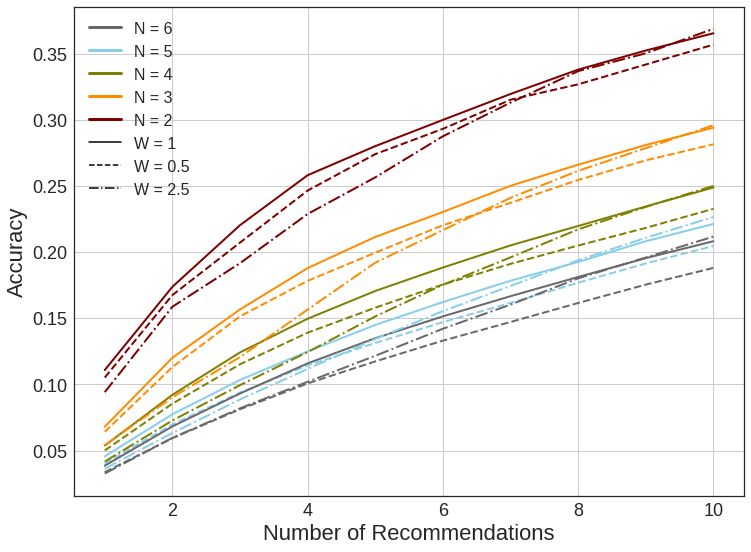

In [0]:
sns.set_style("white")

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

plt.plot( 'x', 'N = 6 W = 0.5', data=df, linestyle='--', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 5 W = 0.5',data=df, linestyle='--', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 4 W = 0.5', data=df, linestyle='--', color='olive', linewidth=2)
plt.plot( 'x', 'N = 3 W = 0.5', data=df, linestyle='--', color='darkorange', linewidth=2)
plt.plot( 'x', 'N = 2 W = 0.5', data=df, linestyle='--', color='maroon', linewidth=2)

plt.plot( 'x', 'N = 6 W = 1', data=df, linestyle='-', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 5 W = 1',data=df, linestyle='-', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 4 W = 1', data=df, linestyle='-', color='olive', linewidth=2)
plt.plot( 'x', 'N = 3 W = 1', data=df, linestyle='-', color='darkorange', linewidth=2)
plt.plot( 'x', 'N = 2 W = 1', data=df, linestyle='-', color='maroon', linewidth=2)

plt.plot( 'x', 'N = 6 W = 2.5', data=df, linestyle='-.', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 5 W = 2.5',data=df, linestyle='-.', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 4 W = 2.5', data=df, linestyle='-.', color='olive', linewidth=2)
plt.plot( 'x', 'N = 3 W = 2.5', data=df, linestyle='-.', color='darkorange', linewidth=2)
plt.plot( 'x', 'N = 2 W = 2.5', data=df, linestyle='-.', color='maroon', linewidth=2)


plt.xlabel('Number of Recommendations', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
plt.grid()


plt.tick_params(labelsize = 18)

custom_lines = [Line2D([0], [0], color='dimgrey', lw=3),
                Line2D([0], [0], color='skyblue', lw=3),
                Line2D([0], [0], color='olive', lw=3),
                Line2D([0], [0], color='darkorange', lw=3),
                Line2D([0], [0], color='maroon', lw=3),
                
                Line2D([0], [0], linestyle = '-', color='black', lw=1.5),
                Line2D([0], [0], linestyle = '--', color='black', lw=1.5),
                Line2D([0], [0], linestyle = '-.', color='black', lw=1.5)]


plt.legend(custom_lines, ['N = 6','N = 5','N = 4','N = 3','N = 2', 'W = 1', 'W = 0.5', 'W = 2.5'], prop={'size': 16})

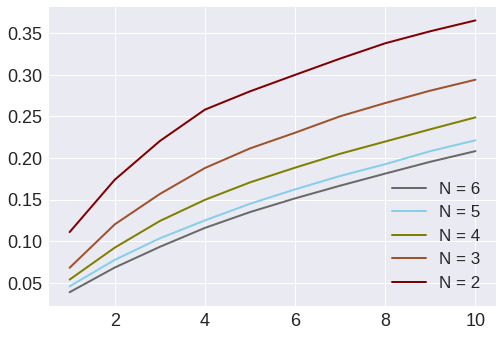

In [0]:
plt.plot( 'x', 'N = 6', data=df1, marker='', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 5',data=df1, marker='', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 4', data=df1, marker='', color='olive', linewidth=2)
plt.plot( 'x', 'N = 3', data=df1, marker='', color='sienna', linewidth=2)
plt.plot( 'x', 'N = 2', data=df1, marker='', color='maroon', linewidth=2)
#plt.ylim(5000,8000)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 17})

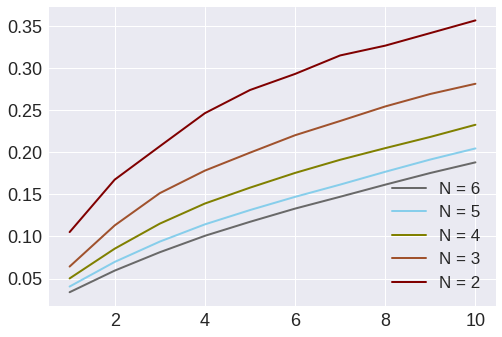

In [0]:
plt.plot( 'x', 'N = 6', data=df05, marker='', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 5',data=df05, marker='', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 4', data=df05, marker='', color='olive', linewidth=2)
plt.plot( 'x', 'N = 3', data=df05, marker='', color='sienna', linewidth=2)
plt.plot( 'x', 'N = 2', data=df05, marker='', color='maroon', linewidth=2)
#plt.ylim(5000,8000)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 17})

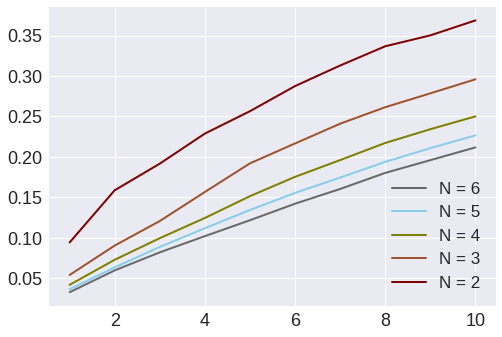

In [0]:
plt.plot( 'x', 'N = 6', data=df25, marker='', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 5',data=df25, marker='', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 4', data=df25, marker='', color='olive', linewidth=2)
plt.plot( 'x', 'N = 3', data=df25, marker='', color='sienna', linewidth=2)
plt.plot( 'x', 'N = 2', data=df25, marker='', color='maroon', linewidth=2)
#plt.ylim(5000,8000)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 17})

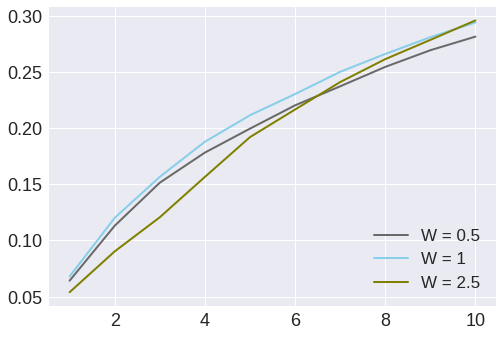

In [0]:
plt.plot( 'x', 'N = 3', data=df05, label = 'W = 0.5', marker='', color='dimgrey', linewidth=2)
plt.plot( 'x', 'N = 3',data=df1, label = 'W = 1', marker='', color='skyblue', linewidth=2)
plt.plot( 'x', 'N = 3', data=df25, label = 'W = 2.5', marker='', color='olive', linewidth=2)

#plt.ylim(5000,8000)
plt.tick_params(labelsize = 18)
plt.legend(loc='lower right', prop={'size': 17})